In [ ]:
%%capture
!apt-get update
!apt-get install -y texlive texlive-latex-extra texlive-fonts-recommended dvipng cm-super

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import eval_legendre, lpmv, spherical_jn, spherical_yn
from scipy import integrate
from scipy.integrate import quad
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
from scipy.special import eval_legendre
from scipy.misc import derivative
from matplotlib.ticker import ScalarFormatter
from matplotlib.colors import LinearSegmentedColormap
from scipy.signal import find_peaks
from matplotlib.ticker import LogLocator, LogFormatter
import matplotlib.ticker as ticker


dpi= 300
px = 1e0/dpi

plt.rcParams.update({
    "text.usetex"   : False,
    "figure.dpi"    : dpi,
    #"text.latex.preamble" : r"\usepackage{lmodern}",
    "font.family" : "sans-serif",
#    "figure.figsize": (800*px,600*px)
})
plt.rcParams['text.usetex'] = True

B = 1
f = 1
c1 = 343e0
c0 = 1522e0


rho1 = 1.205
rho0 = 1024e0

m = c0 / c1

k0 = 2*np.pi*f/c0
k1 = 2*np.pi*f/c1
x0_max = 10
a = 0.1e0
x0_range = np.arange(0,0.2,1e-5)
q= 2*f/(c1*rho1*B**2)
mt = (rho0/rho1)*m
w = 2*np.pi*f

In [ ]:
J = lambda n, x: (spherical_jn(n, x) if n > -1 else spherical_yn(-n-1, x) * ((-1)**n))
H = lambda n, x: (spherical_jn(n, x) + 1j * spherical_yn(n, x)) if n > -1 else ((spherical_yn(-n-1, x) - 1j * spherical_jn(-n-1, x)) * ((-1)**n))

dJ = lambda n, x: (spherical_jn(n, x, derivative=True) if n > -1 else spherical_yn(-n-1, x, derivative=True) * ((-1)**n))
dH = lambda n, x: (spherical_jn(n, x, derivative=True) + 1j * spherical_yn(n, x, derivative=True)) if n > -1 else ((spherical_yn(-n-1, x, derivative=True) - 1j * spherical_jn(-n-1, x, derivative=True)) * ((-1)**n))

def b_l(l, m, mt, x0, x1):
    J = lambda n, x: (spherical_jn(n, x) if n > -1 else spherical_yn(-n-1, x) * ((-1)**n))
    H = lambda n, x: (spherical_jn(n, x) + 1j * spherical_yn(n, x)) if n > -1 else ((spherical_yn(-n-1, x) - 1j * spherical_jn(-n-1, x)) * ((-1)**n))

    dJ = lambda n, x: (spherical_jn(n, x, derivative=True) if n > -1 else spherical_yn(-n-1, x, derivative=True) * ((-1)**n))
    dH = lambda n, x: (spherical_jn(n, x, derivative=True) + 1j * spherical_yn(n, x, derivative=True)) if n > -1 else ((spherical_yn(-n-1, x, derivative=True) - 1j * spherical_jn(-n-1, x, derivative=True)) * ((-1)**n))

    tmp = (J(l, x1) * dH(l, x0) - mt * dJ(l, x1) * H(l, x0))

    if tmp == 0:
        raise ValueError("Denominator in the calculation of bl is zero, which will cause a division by zero error.")

    bl = 1j * (mt / m) / (tmp * (x0**2))

    return bl

def I_1(l, x1, k1):
    integrand = lambda x: (J(l, x)**2)
    result, _ = quad(integrand, 0, x1, epsabs=1.0e-8, epsrel=1.0e-8)
    return  result

def I_2(l, x1, k1):
    integrand = lambda x: x * J(l, x) * J(l + 1, x)
    result, _ = quad(integrand, 0, x1, epsabs=1.0e-8, epsrel=1.0e-8)
    return result

def ell_max(x0):
    return 3 + x0 + 4.05 * x0**(1/3)

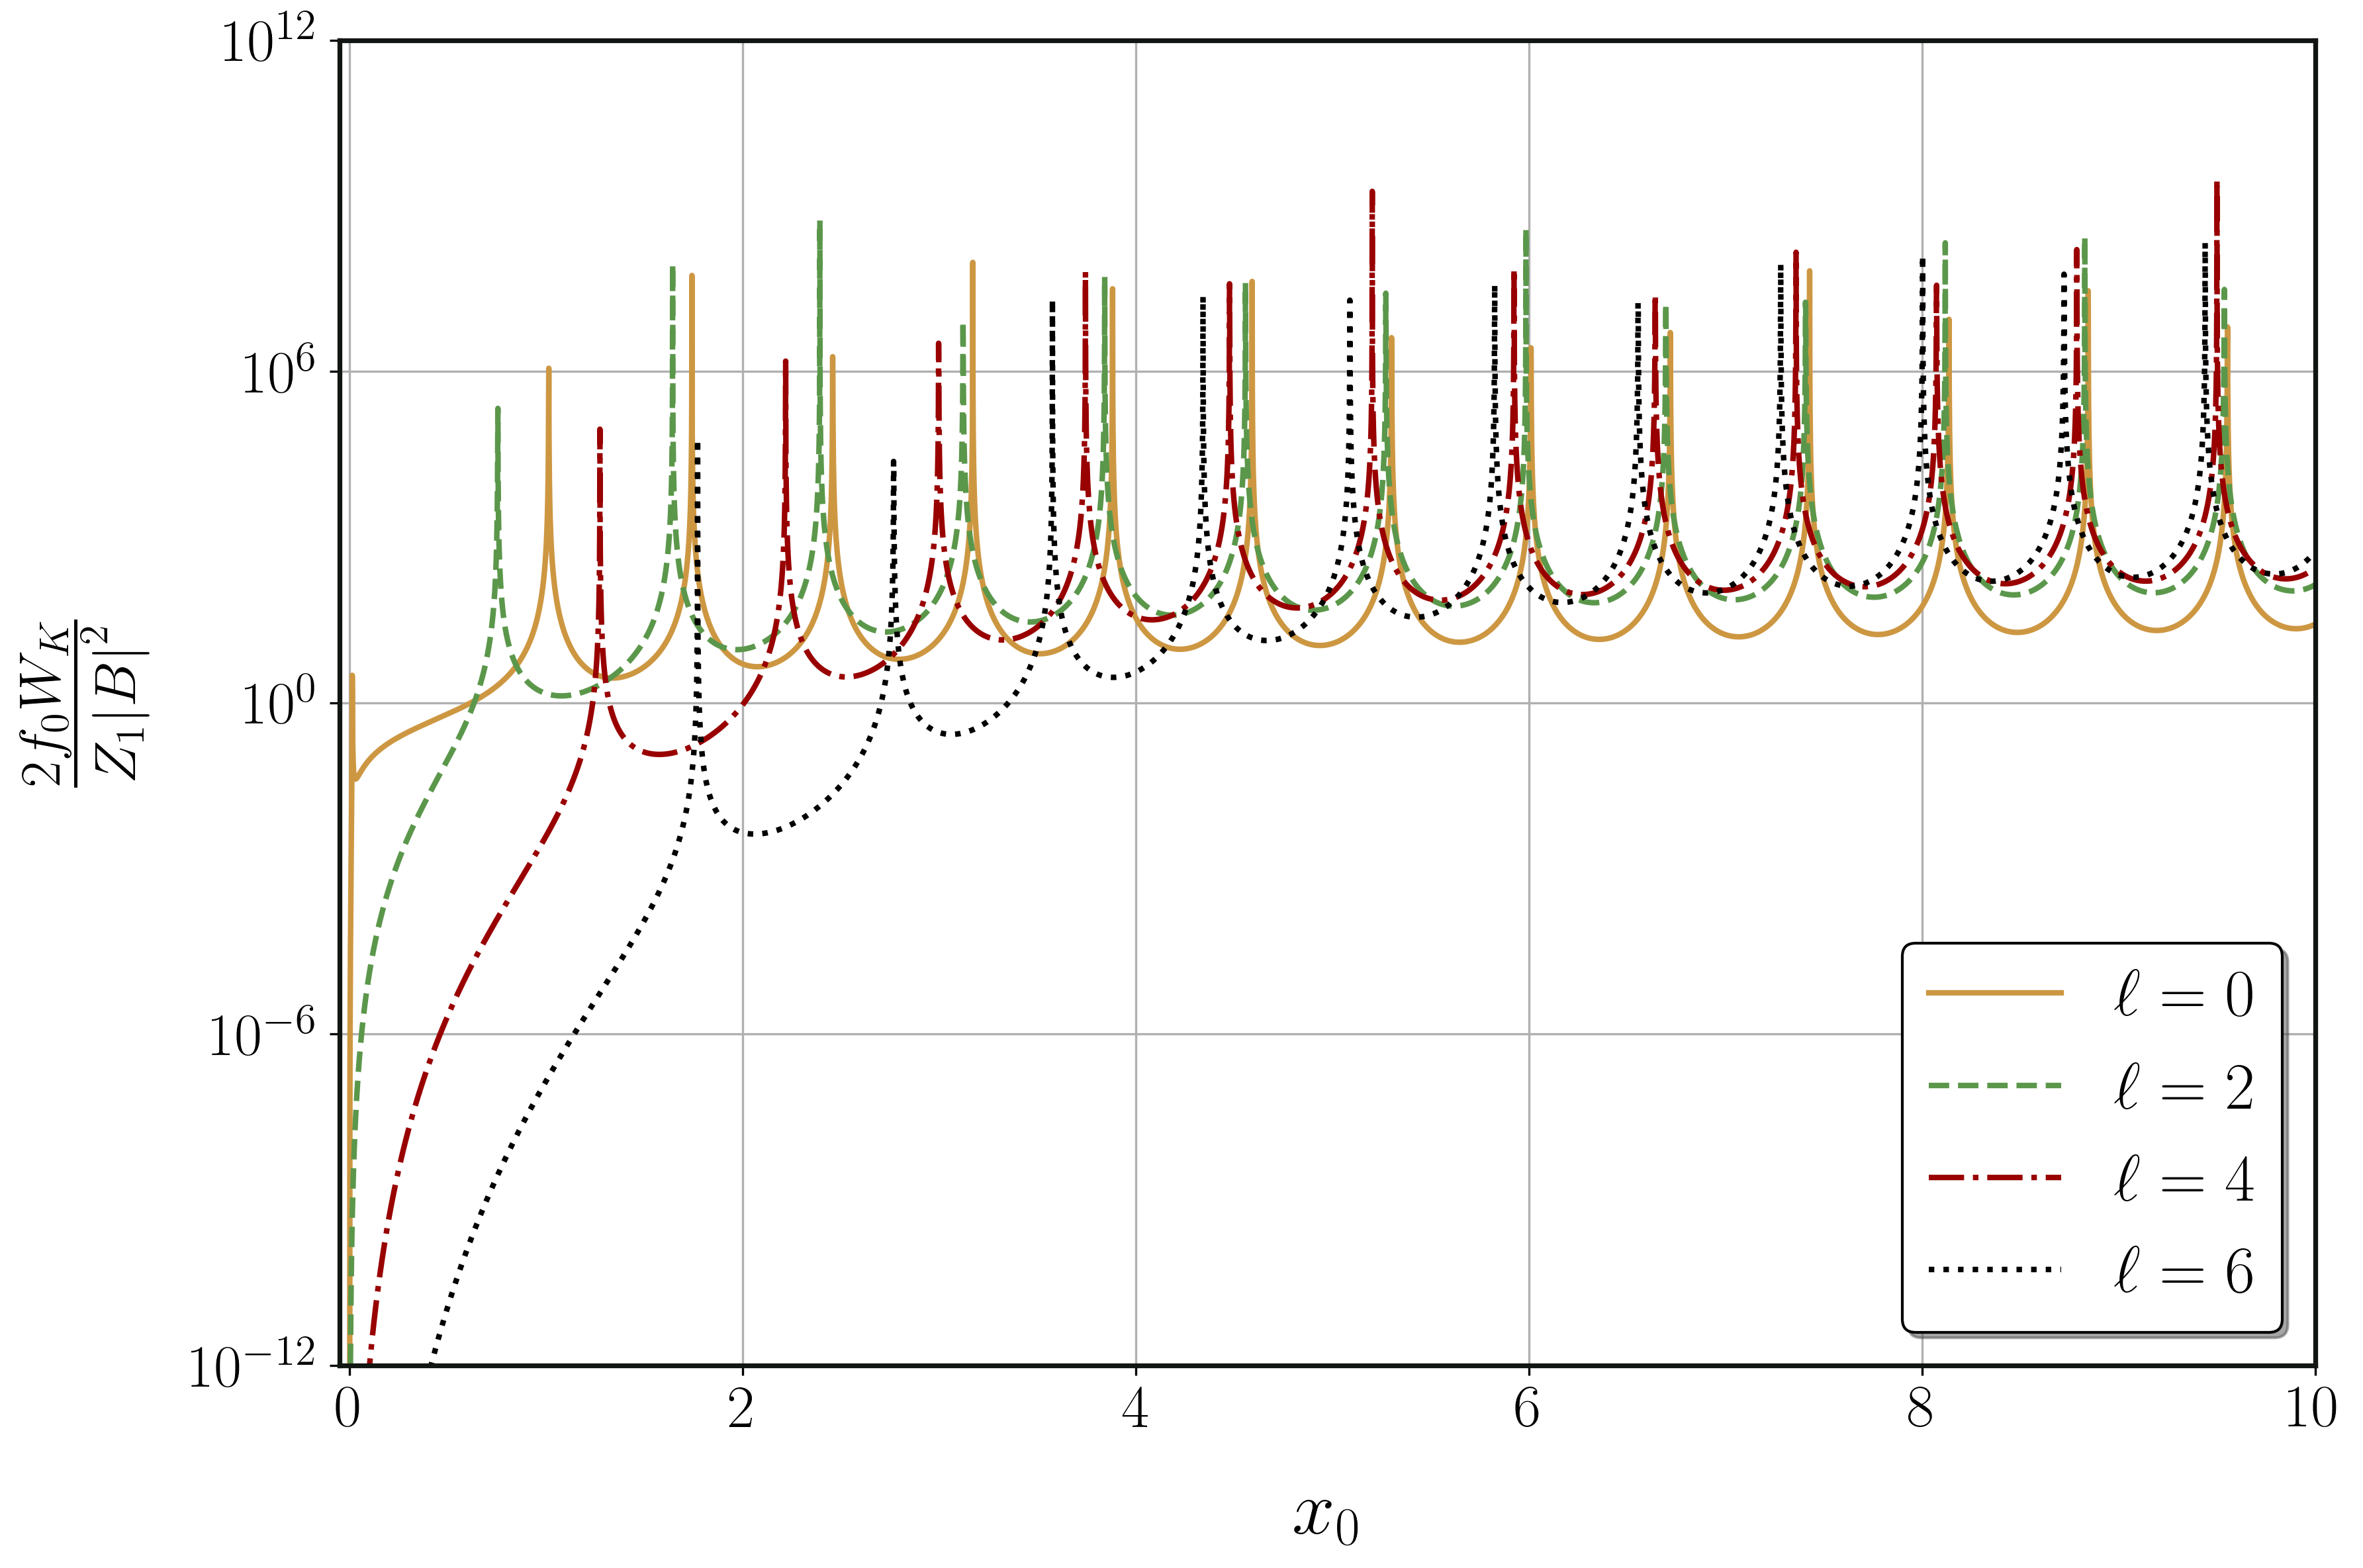

In [ ]:
x0_range_oe = np.arange(1e-5, 10, 1e-3)
even_l_values = [l for l in range(0, 8) if l % 2 == 0]
colors_even = ['#cd9742', '#5b974b', '#990000', 'black']
linestyles_even = ['-', '--', '-.', ':', '-.', '--']
odd_l_values = [l for l in range(1, 9) if l % 2 != 0]
colors_odd = ['#cd9742', '#5b974b', '#990000', 'black']
linestyles_odd = ['-', '--', '-.', ':', '-']
linewidth = 2

# Create a new figure for even l values
plt.figure(figsize=(12, 8))

# Plot for even l values
for idx, l in enumerate(even_l_values):
    kinetic_energy = []
    for x0 in x0_range_oe:
        x1 = m * x0
        b_l_value = np.abs(b_l(l, m, mt, x0, x1))**2
        I1_value = I_1(l, x1, k1)
        I2_value = I_2(l, x1, k1)
        kinetic_sum_series =  (x1**3) * b_l_value * (2 * l + 1) * (((2*l**2)/(x1**3))*I1_value + (l/(x1**3))*I1_value -(2*l/(x1**3))* I2_value + ((J(l+1, x1)**2) - J(l, x1) * J(l+2, x1))/2)
        kinetic_energy.append(kinetic_sum_series)

    label = r'$\ell = ' + f'{l}' + r'$'
    plt.plot(x0_range_oe, kinetic_energy, color=colors_even[idx], linestyle=linestyles_even[idx], linewidth=linewidth, label=label)

# Customize plot
plt.yscale('log')
plt.xlabel('$x_0$', fontsize=28, labelpad=15)
plt.ylabel(r'$\frac{2 f_0 W_K}{Z_1\left|B \right|^2}$', fontsize=30, labelpad=15)

# Customize y-ticks spacing and format
plt.gca().yaxis.set_major_locator(ticker.LogLocator(numticks=4))
#plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{y:.0e}'))
plt.tick_params(axis='x', which='major', labelsize=22)
plt.tick_params(axis='y', which='major', labelsize=22)
# Add legend and grid
plt.legend(fontsize=24, framealpha=1, edgecolor='black', shadow=True, fancybox=True, loc='lower right')
plt.grid(True)

# Customize axes appearance
for spine in ['bottom', 'left', 'top', 'right']:
    plt.gca().spines[spine].set_color('#111612')
    plt.gca().spines[spine].set_linewidth(1.75)

# Set limits for x and y axes
plt.xlim([-0.05, 10])
plt.ylim([1e-12, 1e12])

# Adjust layout and save the plot
plt.tight_layout()

# Save files
plt.savefig('/content/drive/My Drive/wk_even_01.pdf', dpi=600, bbox_inches='tight', pad_inches=0.1)
plt.savefig('/content/drive/My Drive/wk_even_01.png', dpi=600, bbox_inches='tight', pad_inches=0.1)
plt.savefig('/content/drive/My Drive/wk_even_01.eps', dpi=600, bbox_inches='tight', pad_inches=0.1)

# Show the plot inline
plt.show()

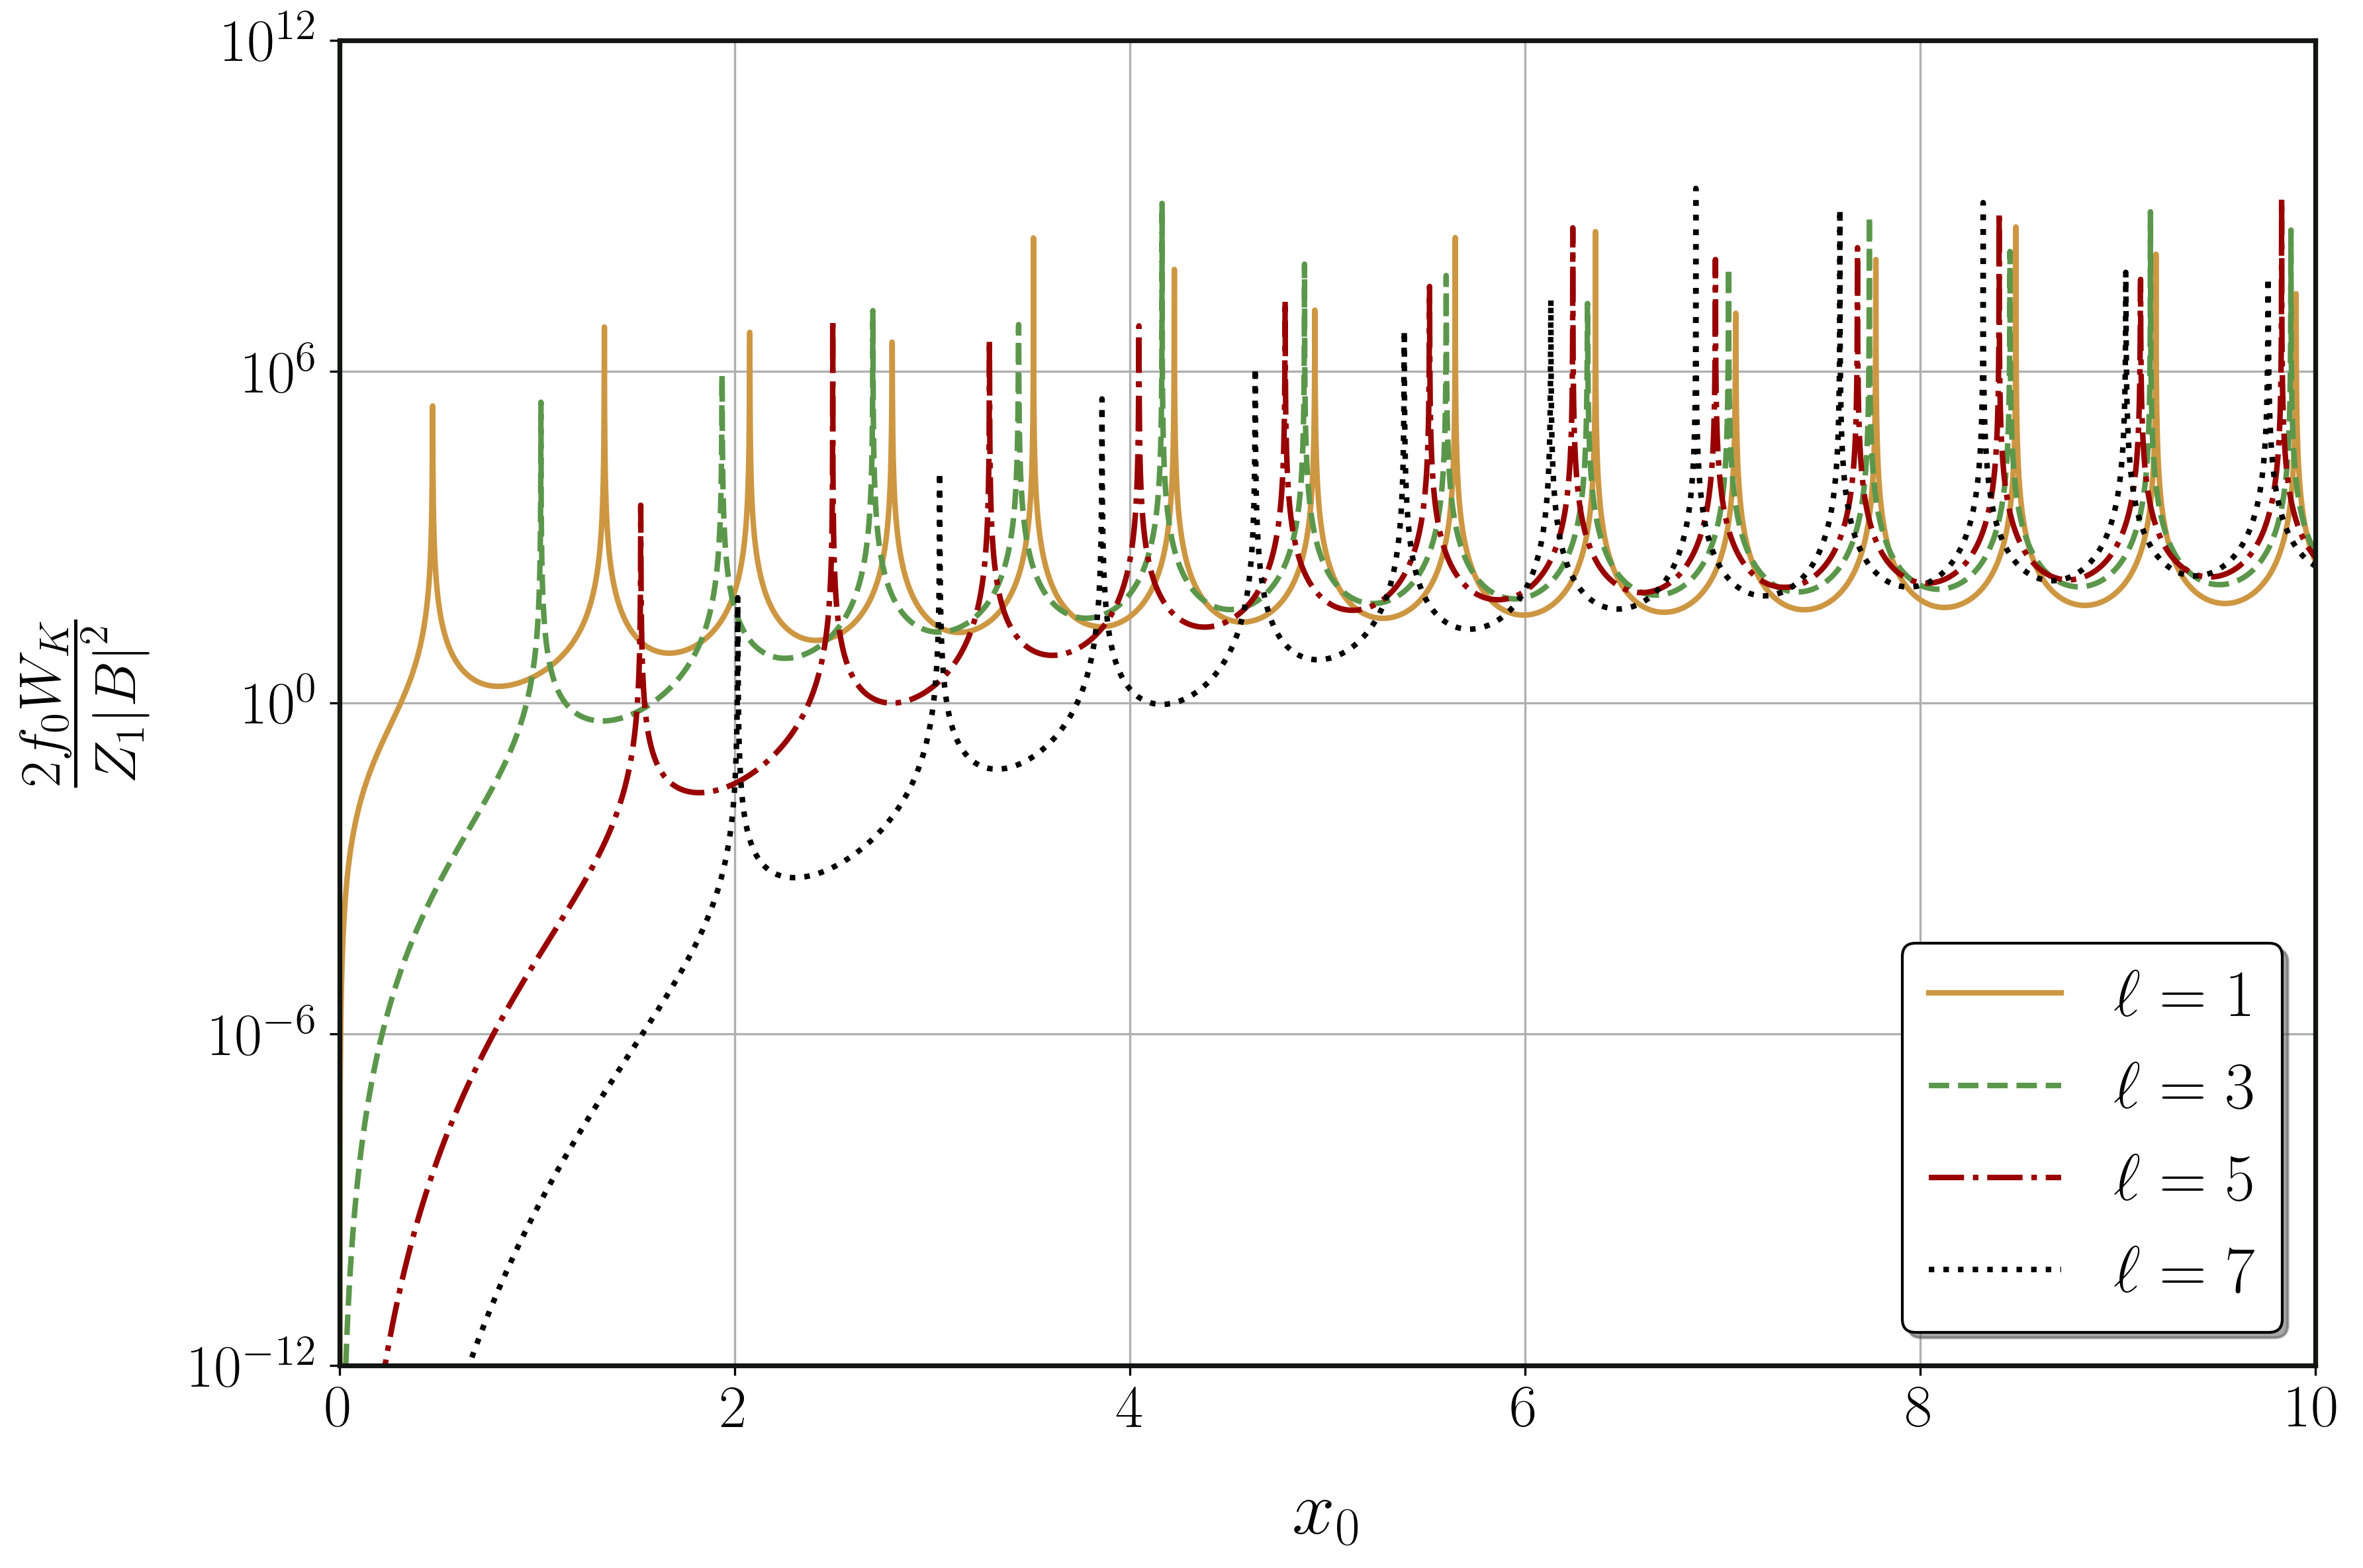

In [ ]:
# Create a new figure for odd l values
plt.figure(figsize=(12, 8))

# Plot for odd l values
for idx, l in enumerate(odd_l_values):
    kinetic_energy = []
    for x0 in x0_range_oe:
        x1 = m * x0
        I1_value = I_1(l, x1, k1)
        I2_value = I_2(l, x1, k1)
        b_l_value = np.abs(b_l(l, m, mt, x0, x1))**2
        kinetic_sum_series = ((x1**3) * b_l_value * (2 * l + 1) * (((2*l**2)/(x1**3))*I1_value + (l/(x1**3))*I1_value -(2*l/(x1**3))* I2_value + ((J(l+1, x1)**2) - J(l, x1) * J(l+2, x1))/2))
        kinetic_energy.append(kinetic_sum_series)

    label = r'$ \ell = ' + f'{l}' + r'$'
    plt.plot(x0_range_oe, kinetic_energy, color=colors_even[idx], linestyle=linestyles_odd[idx], linewidth=linewidth, label=label)

# Customize plot
plt.yscale('log')
plt.xlabel('$x_0$', fontsize=28, labelpad=15)
plt.ylabel(r'$\frac{2 f_0 W_K}{Z_1\left|B \right|^2}$', fontsize=30, labelpad=15)

# Customize y-ticks spacing and format
plt.gca().yaxis.set_major_locator(ticker.LogLocator(numticks=4))
#plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{y:.0e}'))
plt.tick_params(axis='x', which='major', labelsize=22)
plt.tick_params(axis='y', which='major', labelsize=22)
# Add legend and grid
plt.legend(fontsize=24, framealpha=1, edgecolor='black', shadow=True, fancybox=True, loc='lower right')
plt.grid(True)

# Customize axes appearance
for spine in ['bottom', 'left', 'top', 'right']:
    plt.gca().spines[spine].set_color('#111612')
    plt.gca().spines[spine].set_linewidth(1.75)

plt.xlim([0, 10])
plt.ylim([1e-12, 1e12])

# Save the odd l values plot
plt.tight_layout()
plt.savefig('/content/drive/My Drive/wk_odd_01.pdf', dpi=600, bbox_inches='tight', pad_inches=0.1)
plt.savefig('/content/drive/My Drive/wk_odd_01.png', dpi=600, bbox_inches='tight', pad_inches=0.1)
plt.savefig('/content/drive/My Drive/wk_odd_01.eps', dpi=600, bbox_inches='tight', pad_inches=0.1)
plt.show()

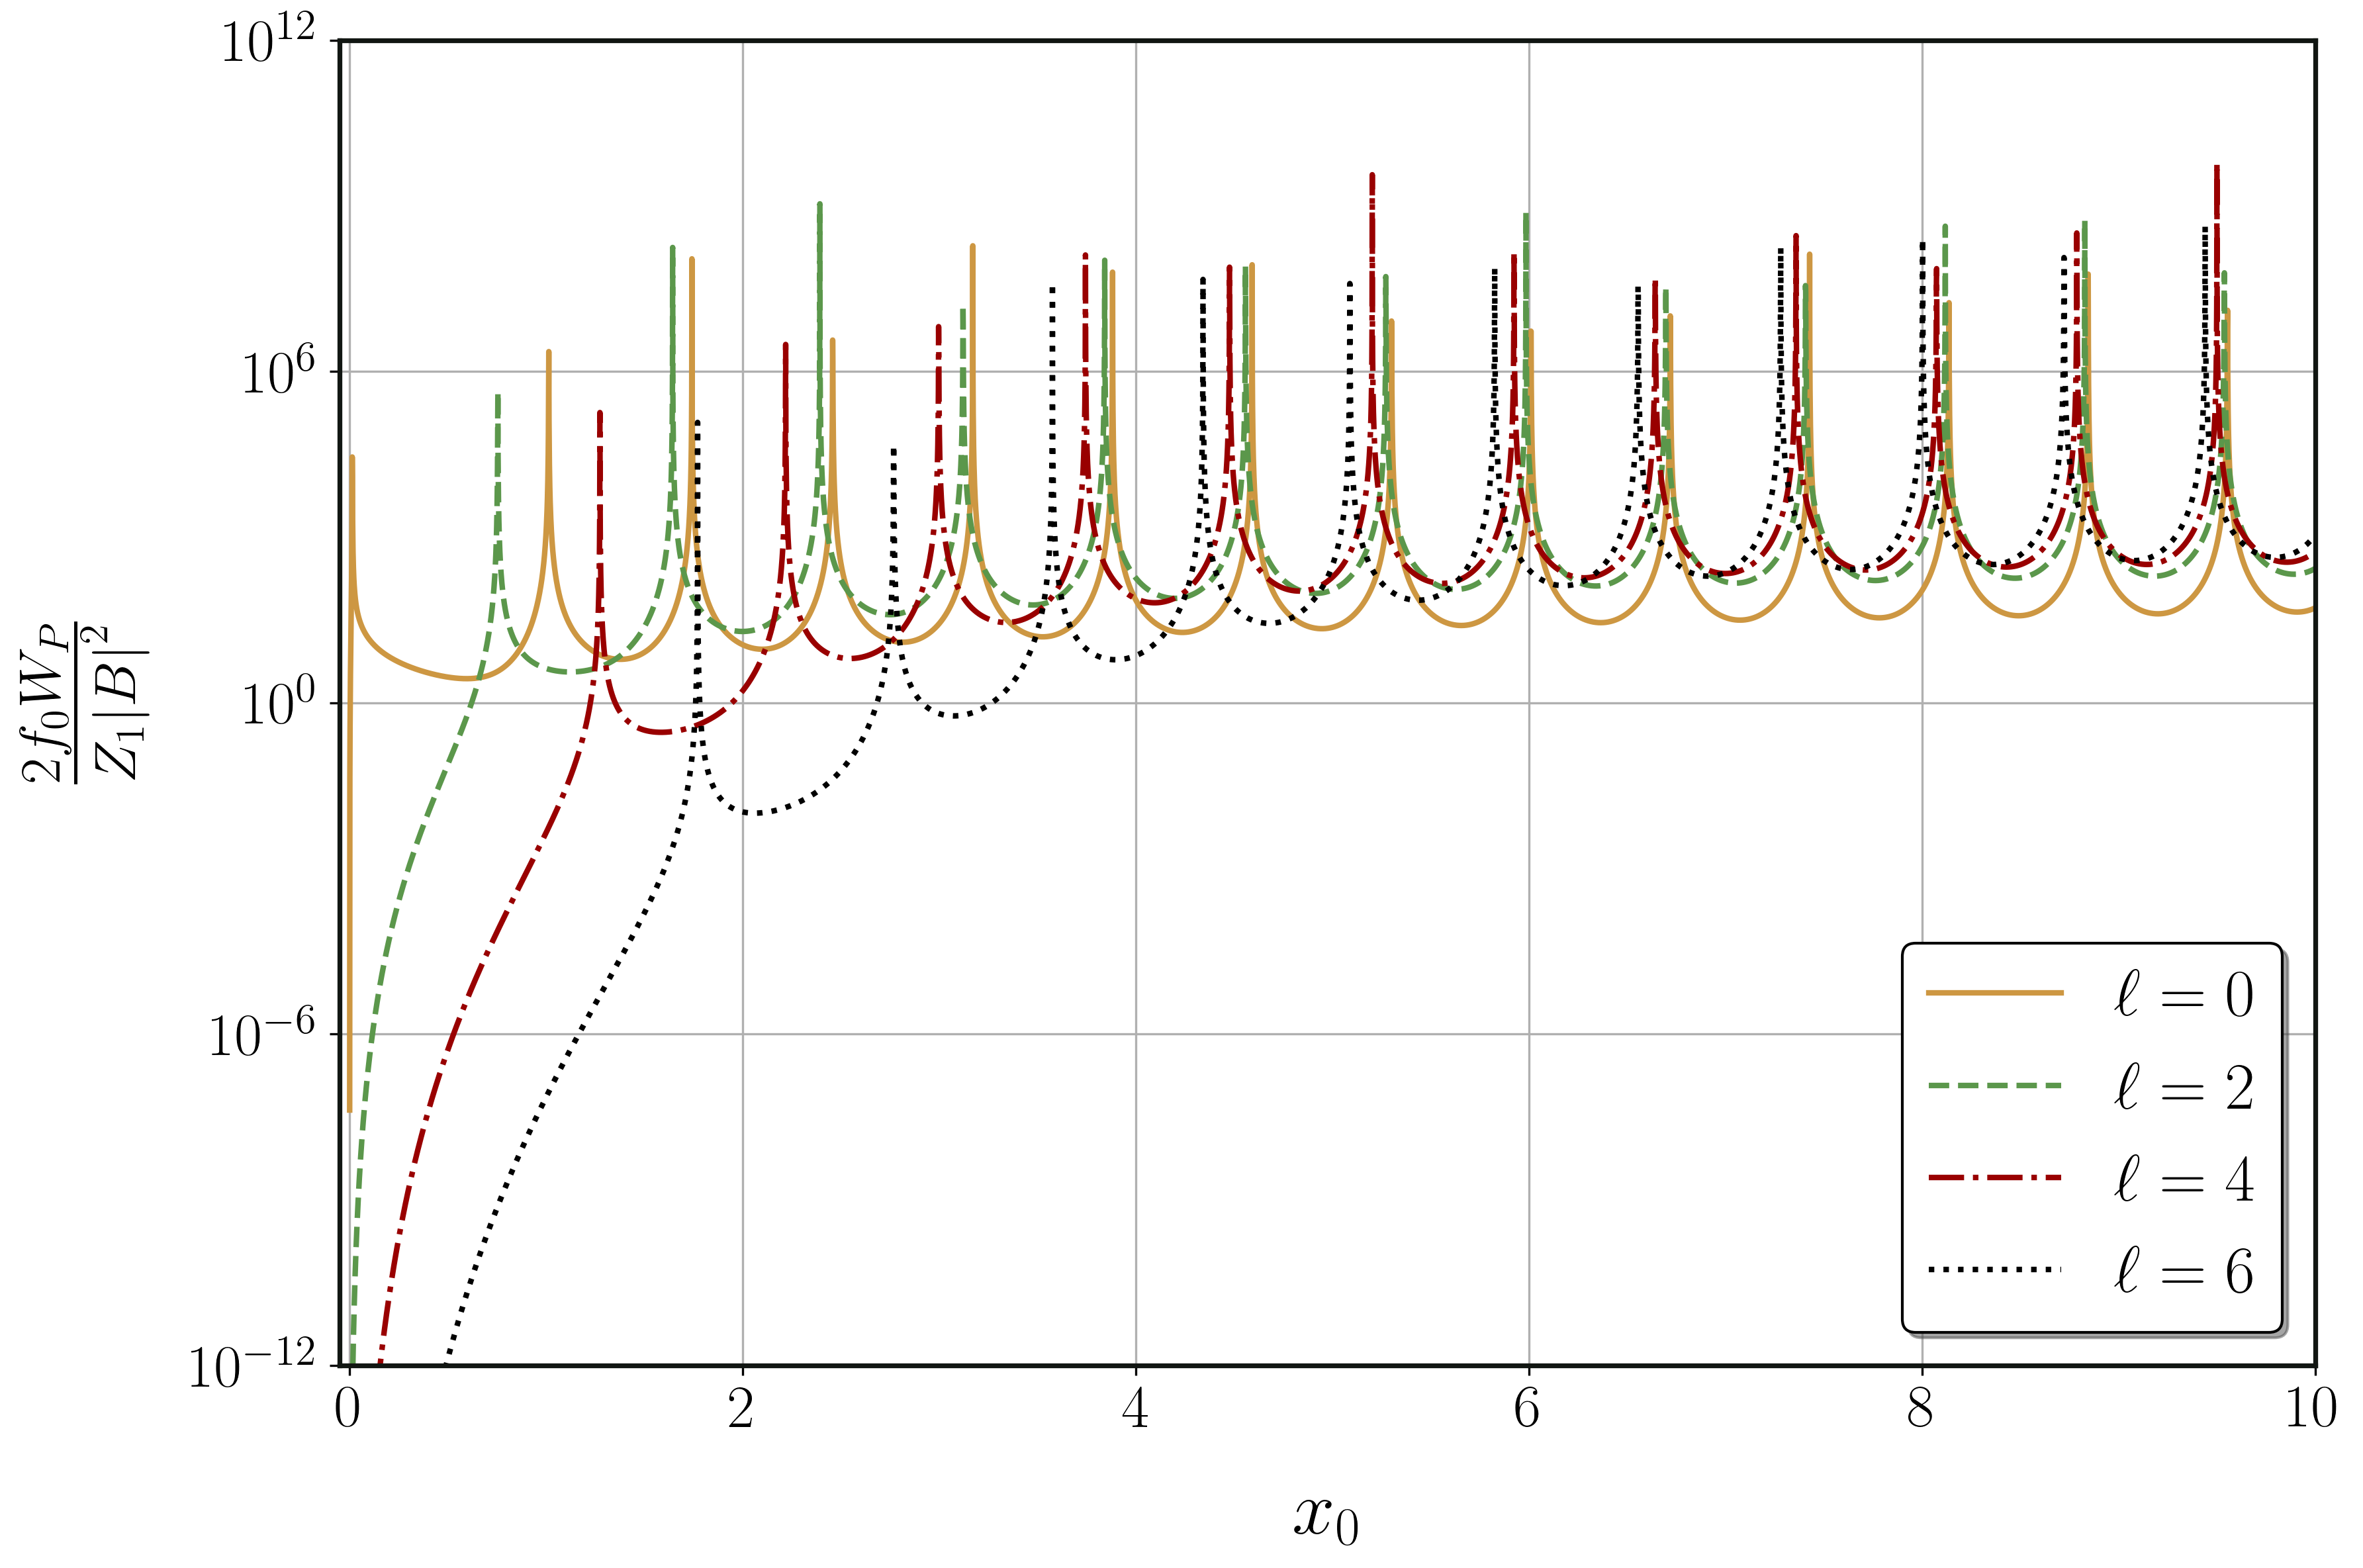

In [ ]:
plt.figure(figsize=(12, 8))

# Plot for even l values
for idx, l in enumerate(even_l_values):
    potential_energy = []
    for x0 in x0_range_oe:
        x1 = m * x0
        b_l_value = np.abs(b_l(l, m, mt, x0, x1))**2
        potential_sum_series = ((x1**3) * b_l_value * (2 * l + 1) * ((J(l, x1)**2) - J(l - 1, x1) * J(l + 1, x1)))
        potential_energy.append(potential_sum_series)

    label = r'$\ell = ' + f'{l}' + r'$'
    plt.plot(x0_range_oe, potential_energy, color=colors_even[idx], linestyle=linestyles_even[idx], linewidth=linewidth, label=label)

plt.yscale('log')
plt.xlabel('$x_0$', fontsize=28, labelpad=15)
plt.ylabel(r'$\frac{2 f_0 W_P}{Z_1\left|B \right|^2}$', fontsize=30, labelpad=15)

# Customize y-ticks spacing and format
plt.gca().yaxis.set_major_locator(ticker.LogLocator(numticks=4))
#plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{y:.0e}'))
plt.tick_params(axis='x', which='major', labelsize=22)
plt.tick_params(axis='y', which='major', labelsize=22)
# Add legend and grid
plt.legend(fontsize=24, framealpha=1, edgecolor='black', shadow=True, fancybox=True, loc='lower right')
plt.grid(True)

# Customize axes appearance
for spine in ['bottom', 'left', 'top', 'right']:
    plt.gca().spines[spine].set_color('#111612')
    plt.gca().spines[spine].set_linewidth(1.75)

plt.xlim([-0.05, 10])
plt.ylim([1e-12, 1e12])

# Save the even l values plot
plt.tight_layout()
plt.savefig('/content/drive/My Drive/wp_even_01.pdf', dpi=600, bbox_inches='tight', pad_inches=0.1)
plt.savefig('/content/drive/My Drive/wp_even_01.png', dpi=600, bbox_inches='tight', pad_inches=0.1)
plt.savefig('/content/drive/My Drive/wp_even_01.eps', dpi=600, bbox_inches='tight', pad_inches=0.1)
plt.show()

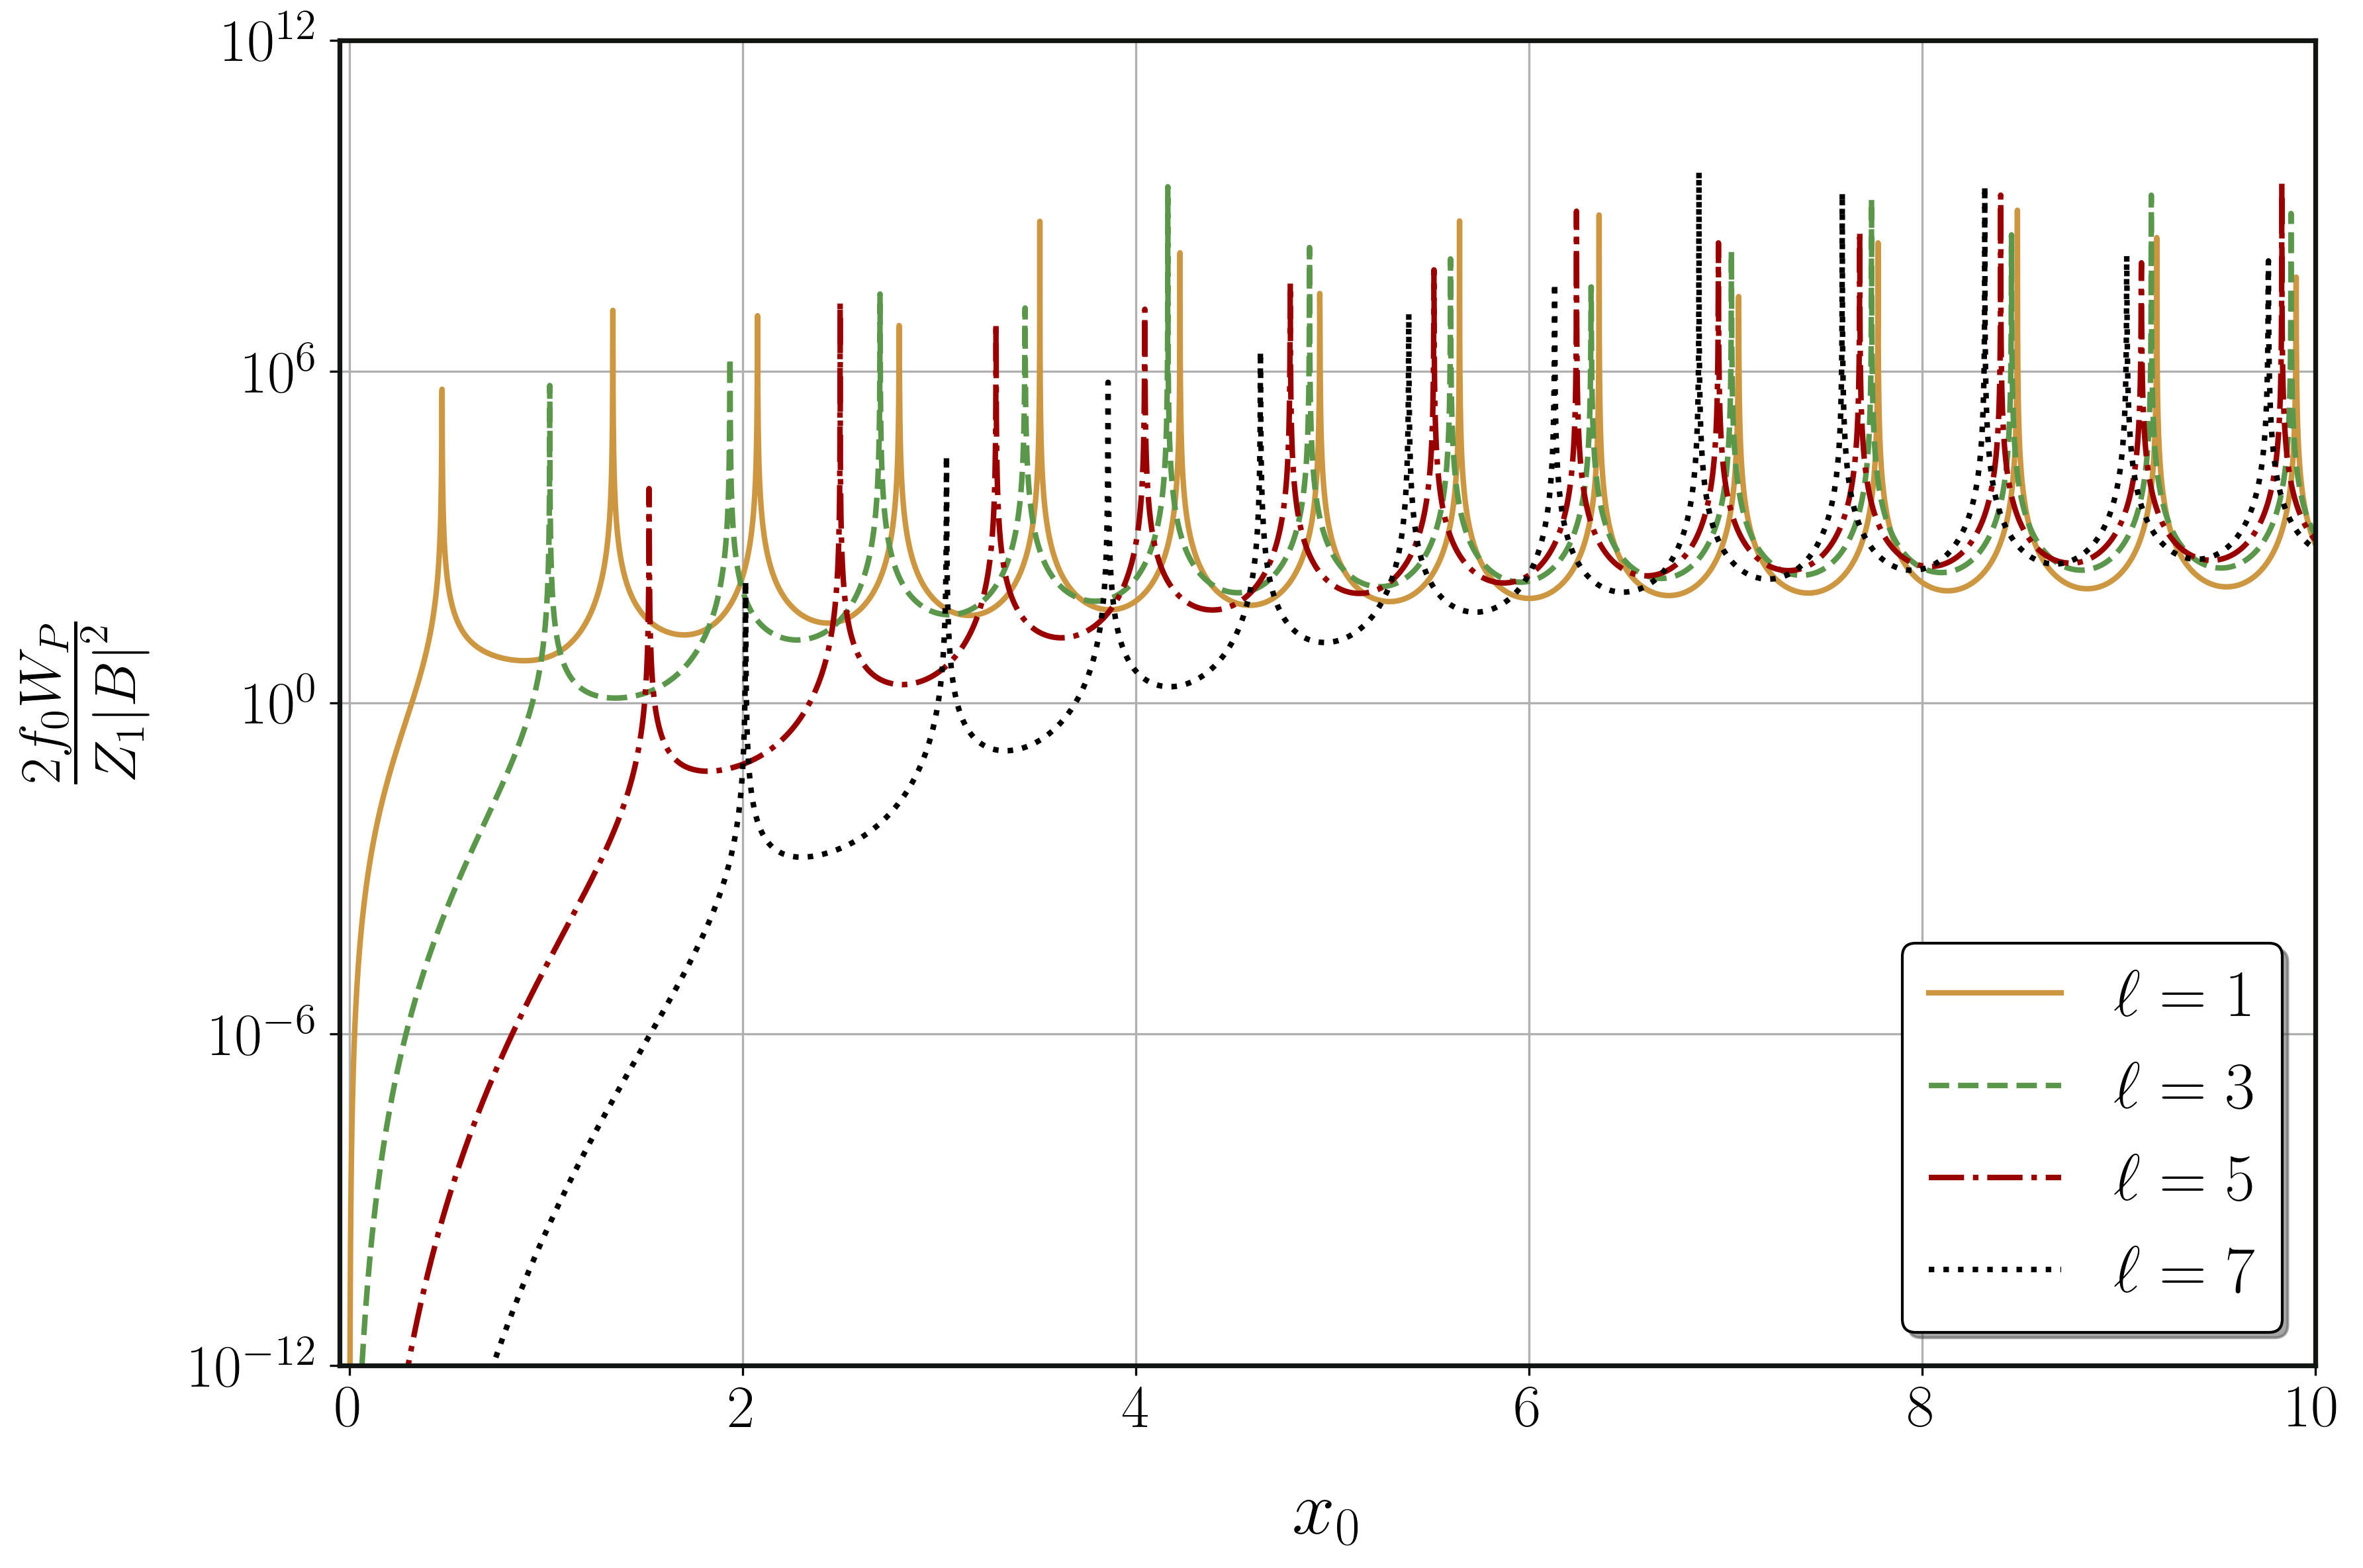

In [ ]:
plt.figure(figsize=(12, 8))

# Plot for even l values
for idx, l in enumerate(odd_l_values):
    potential_energy = []
    for x0 in x0_range_oe:
        x1 = m * x0
        b_l_value = np.abs(b_l(l, m, mt, x0, x1))**2
        potential_sum_series = ((x1**3) * b_l_value * (2 * l + 1) * ((J(l, x1)**2) - J(l - 1, x1) * J(l + 1, x1)))
        potential_energy.append(potential_sum_series)

    label = r'$\ell = ' + f'{l}' + r'$'
    plt.plot(x0_range_oe, potential_energy, color=colors_even[idx], linestyle=linestyles_even[idx], linewidth=linewidth, label=label)

plt.yscale('log')
plt.xlabel('$x_0$', fontsize=28, labelpad=15)
plt.ylabel(r'$\frac{2 f_0 W_P}{Z_1\left|B \right|^2}$', fontsize=30, labelpad=15)

# Customize y-ticks spacing and format
plt.gca().yaxis.set_major_locator(ticker.LogLocator(numticks=4))
#plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{y:.0e}'))
plt.tick_params(axis='x', which='major', labelsize=22)
plt.tick_params(axis='y', which='major', labelsize=22)
# Add legend and grid
plt.legend(fontsize=24, framealpha=1, edgecolor='black', shadow=True, fancybox=True, loc='lower right')
plt.grid(True)

# Customize axes appearance
for spine in ['bottom', 'left', 'top', 'right']:
    plt.gca().spines[spine].set_color('#111612')
    plt.gca().spines[spine].set_linewidth(1.75)

plt.xlim([-0.05, 10])
plt.ylim([1e-12, 1e12])

# Save the even l values plot
plt.tight_layout()
plt.savefig('/content/drive/My Drive/wp_odd_01.pdf', dpi=600, bbox_inches='tight', pad_inches=0.1)
plt.savefig('/content/drive/My Drive/wp_odd_01.png', dpi=600, bbox_inches='tight', pad_inches=0.1)
plt.savefig('/content/drive/My Drive/wp_odd_01.eps', dpi=600, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [ ]:
kinetic_energy = []
potential_energy = []
x0_range = np.arange(1e-5,0.2,1e-5)
for x0 in x0_range:
    l_max = int(ell_max(x0_max))
    kinetic_sum_series = 0
    potential_sum_series = 0
    for l in range(0, l_max):
        x1 = m * x0
        b_l_value = np.abs(b_l(l, m, mt, x0, x1))**2
        I1_value = I_1(l, x1, k1)
        I2_value = I_2(l, x1, k1)
        kinetic_sum_series += (x1**3) * b_l_value * (2 * l + 1) * (((2*l**2)/(x1**3))*I1_value + (l/(x1**3))*I1_value -(2*l/(x1**3))* I2_value + ((J(l+1, x1)**2) - J(l, x1) * J(l+2, x1))/2)
        potential_sum_series += (x1**3) * b_l_value * (2 * l + 1) * ((J(l, x1)**2) - J(l - 1, x1) * J(l + 1, x1))
    kinetic_energy_value = kinetic_sum_series
    kinetic_energy.append(kinetic_energy_value)
    potential_energy_value = potential_sum_series
    potential_energy.append(potential_energy_value)

kinetic_energy = np.array(kinetic_energy)
potential_energy = np.array(potential_energy)

x0_range_low_precision = np.arange(1e-5,10,1e-3)
kinetic_energy_low_precision = []
potential_energy_low_precision  = []

for x0 in x0_range_low_precision:
    l_max = int(ell_max(x0_max))
    kinetic_sum_series_low_precision = 0
    potential_sum_series_low_precision = 0
    for l in range(0,l_max):
        x1 = m*x0
        b_l_value = np.abs(b_l(l, m, mt, x0, x1))
        I1_value = I_1(l, x1, k1)
        I2_value = I_2(l, x1, k1)
        kinetic_sum_series_low_precision += (x1**3) * b_l_value * (2 * l + 1) * (((2*l**2)/(x1**3))*I1_value + (l/(x1**3))*I1_value -(2*l/(x1**3))* I2_value + ((J(l+1, x1)**2) - J(l, x1) * J(l+2, x1))/2)
        potential_sum_series_low_precision += (x1**3) * b_l_value * (2 * l + 1) * ((J(l, x1)**2) - J(l - 1, x1) * J(l + 1, x1))
    kinetic_energy_value_low_precision = (kinetic_sum_series_low_precision)
    kinetic_energy_low_precision.append(kinetic_energy_value_low_precision)
    potential_energy_value_low_precision = (potential_sum_series_low_precision)
    potential_energy_low_precision.append(potential_energy_value_low_precision)

kinetic_energy_low_precision = np.array(kinetic_energy_low_precision)
potential_energy_low_precision = np.array(potential_energy_low_precision)

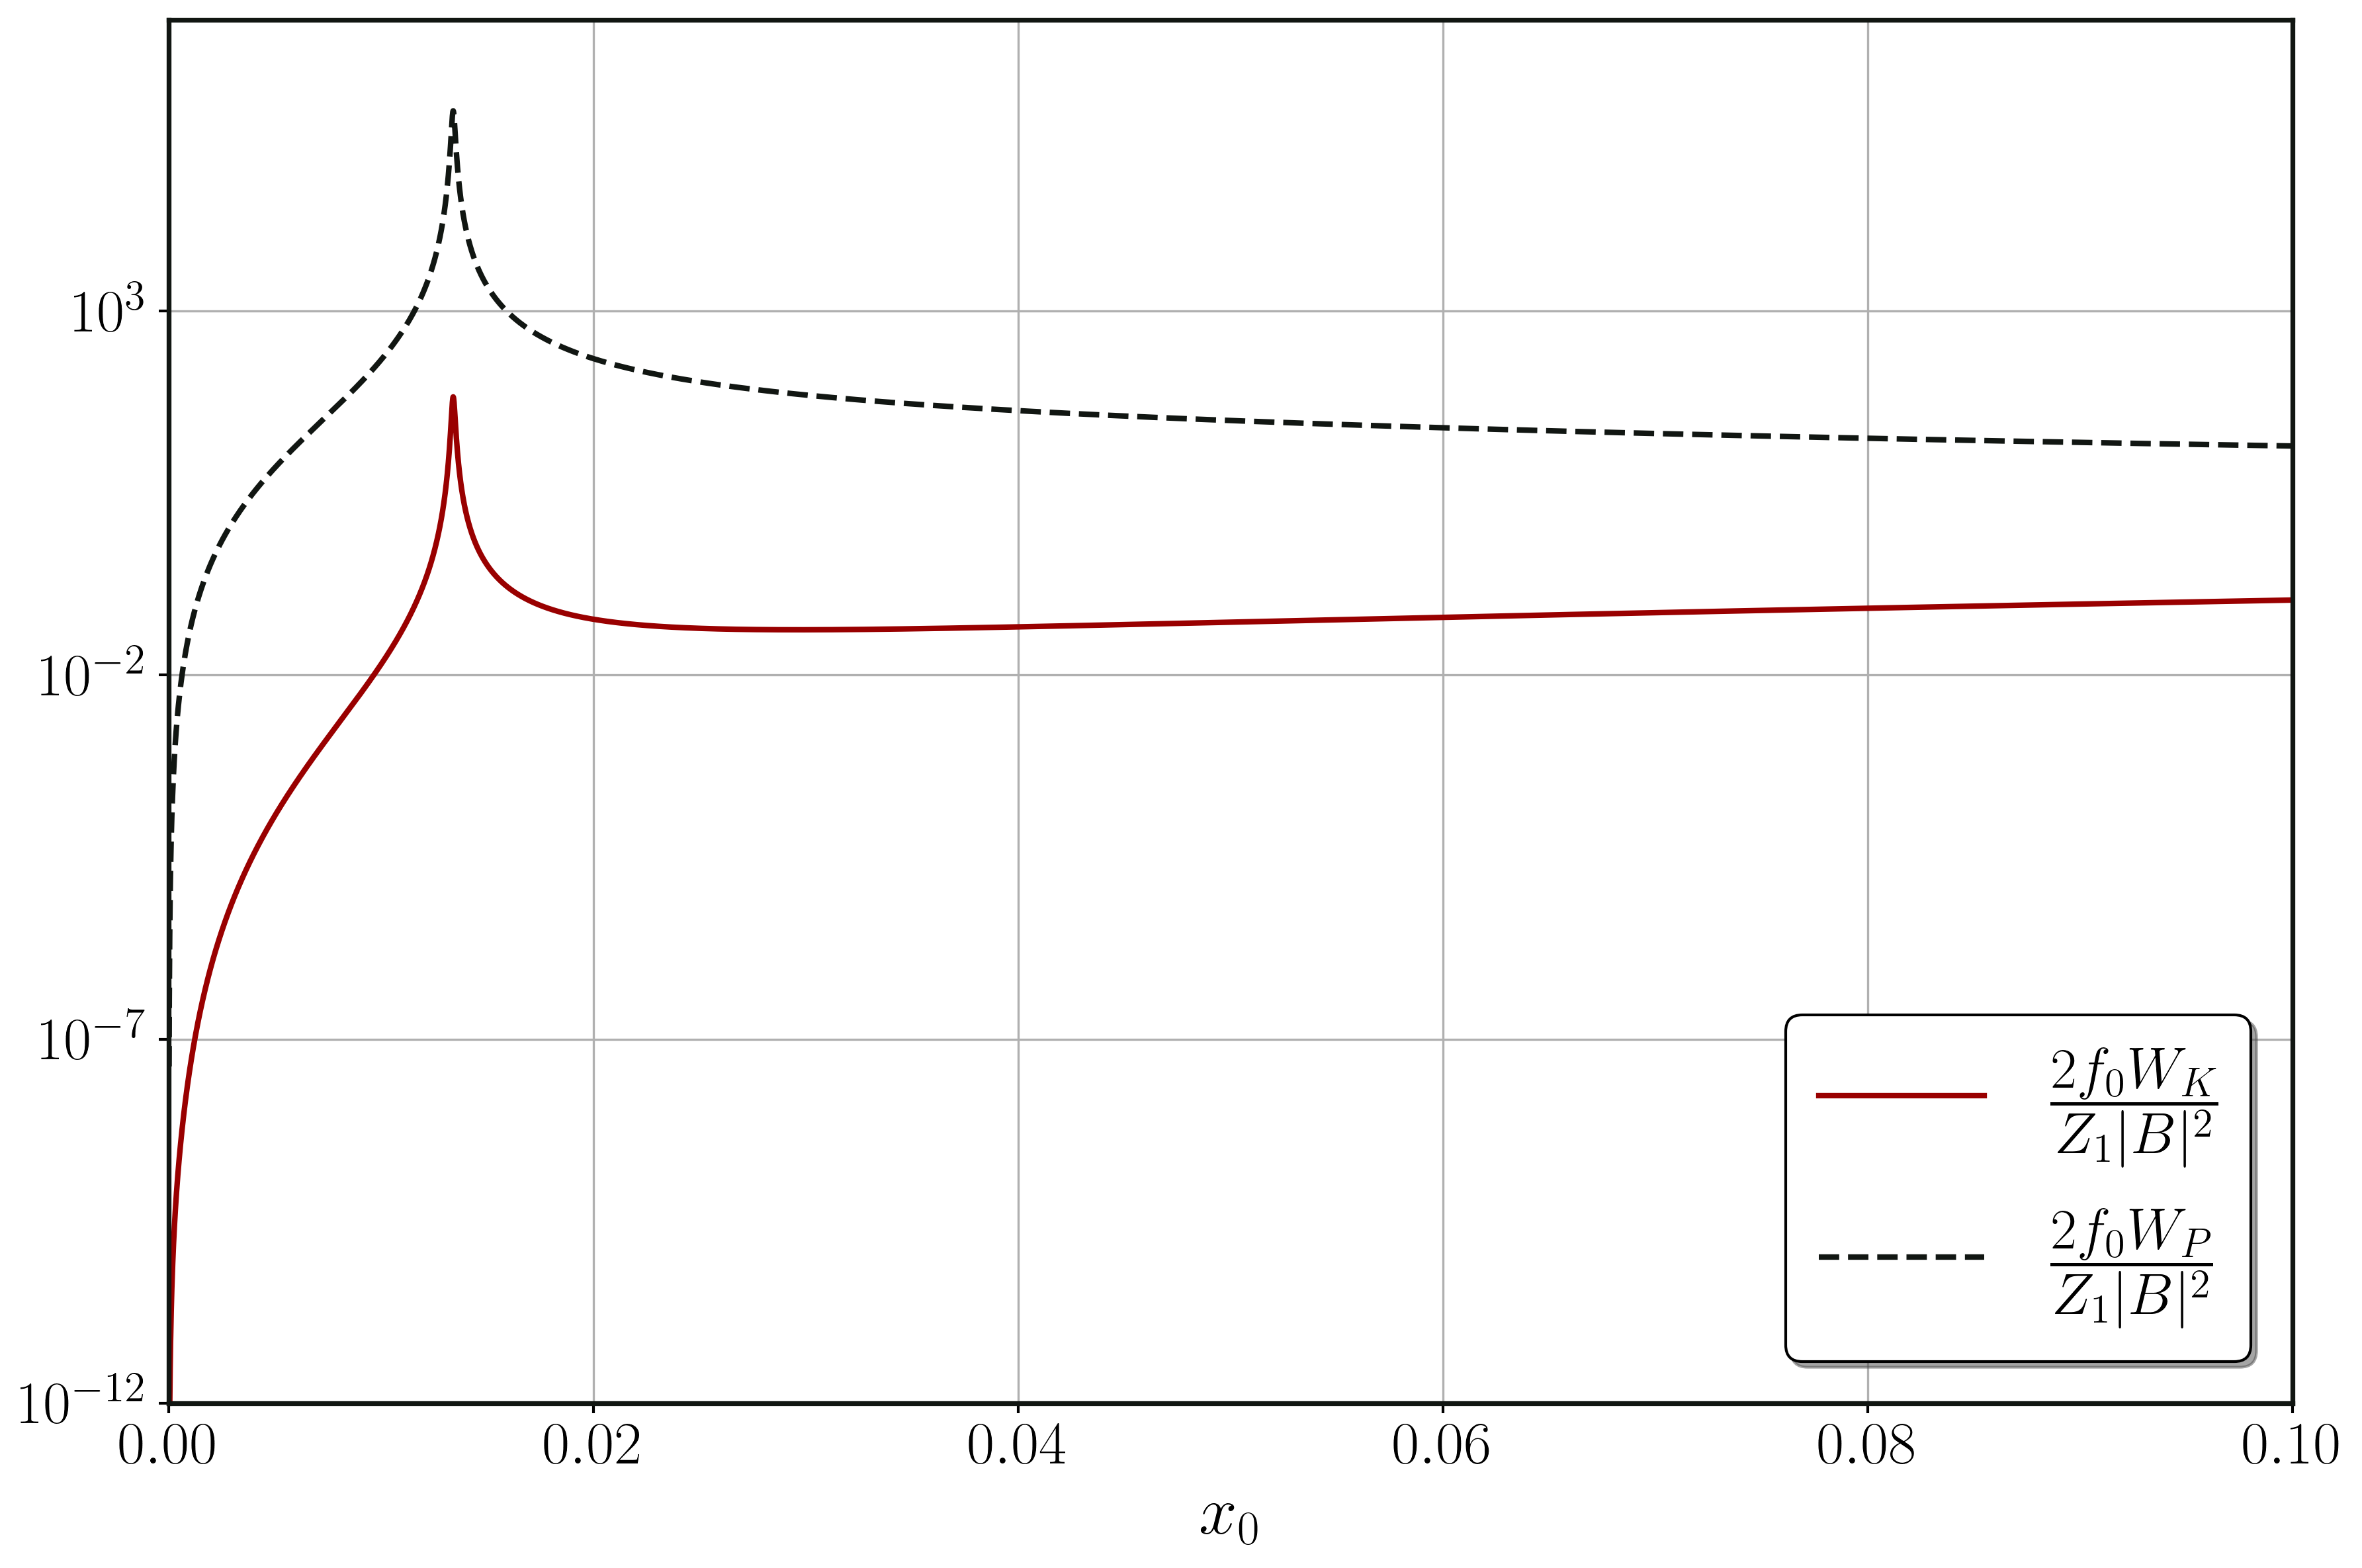

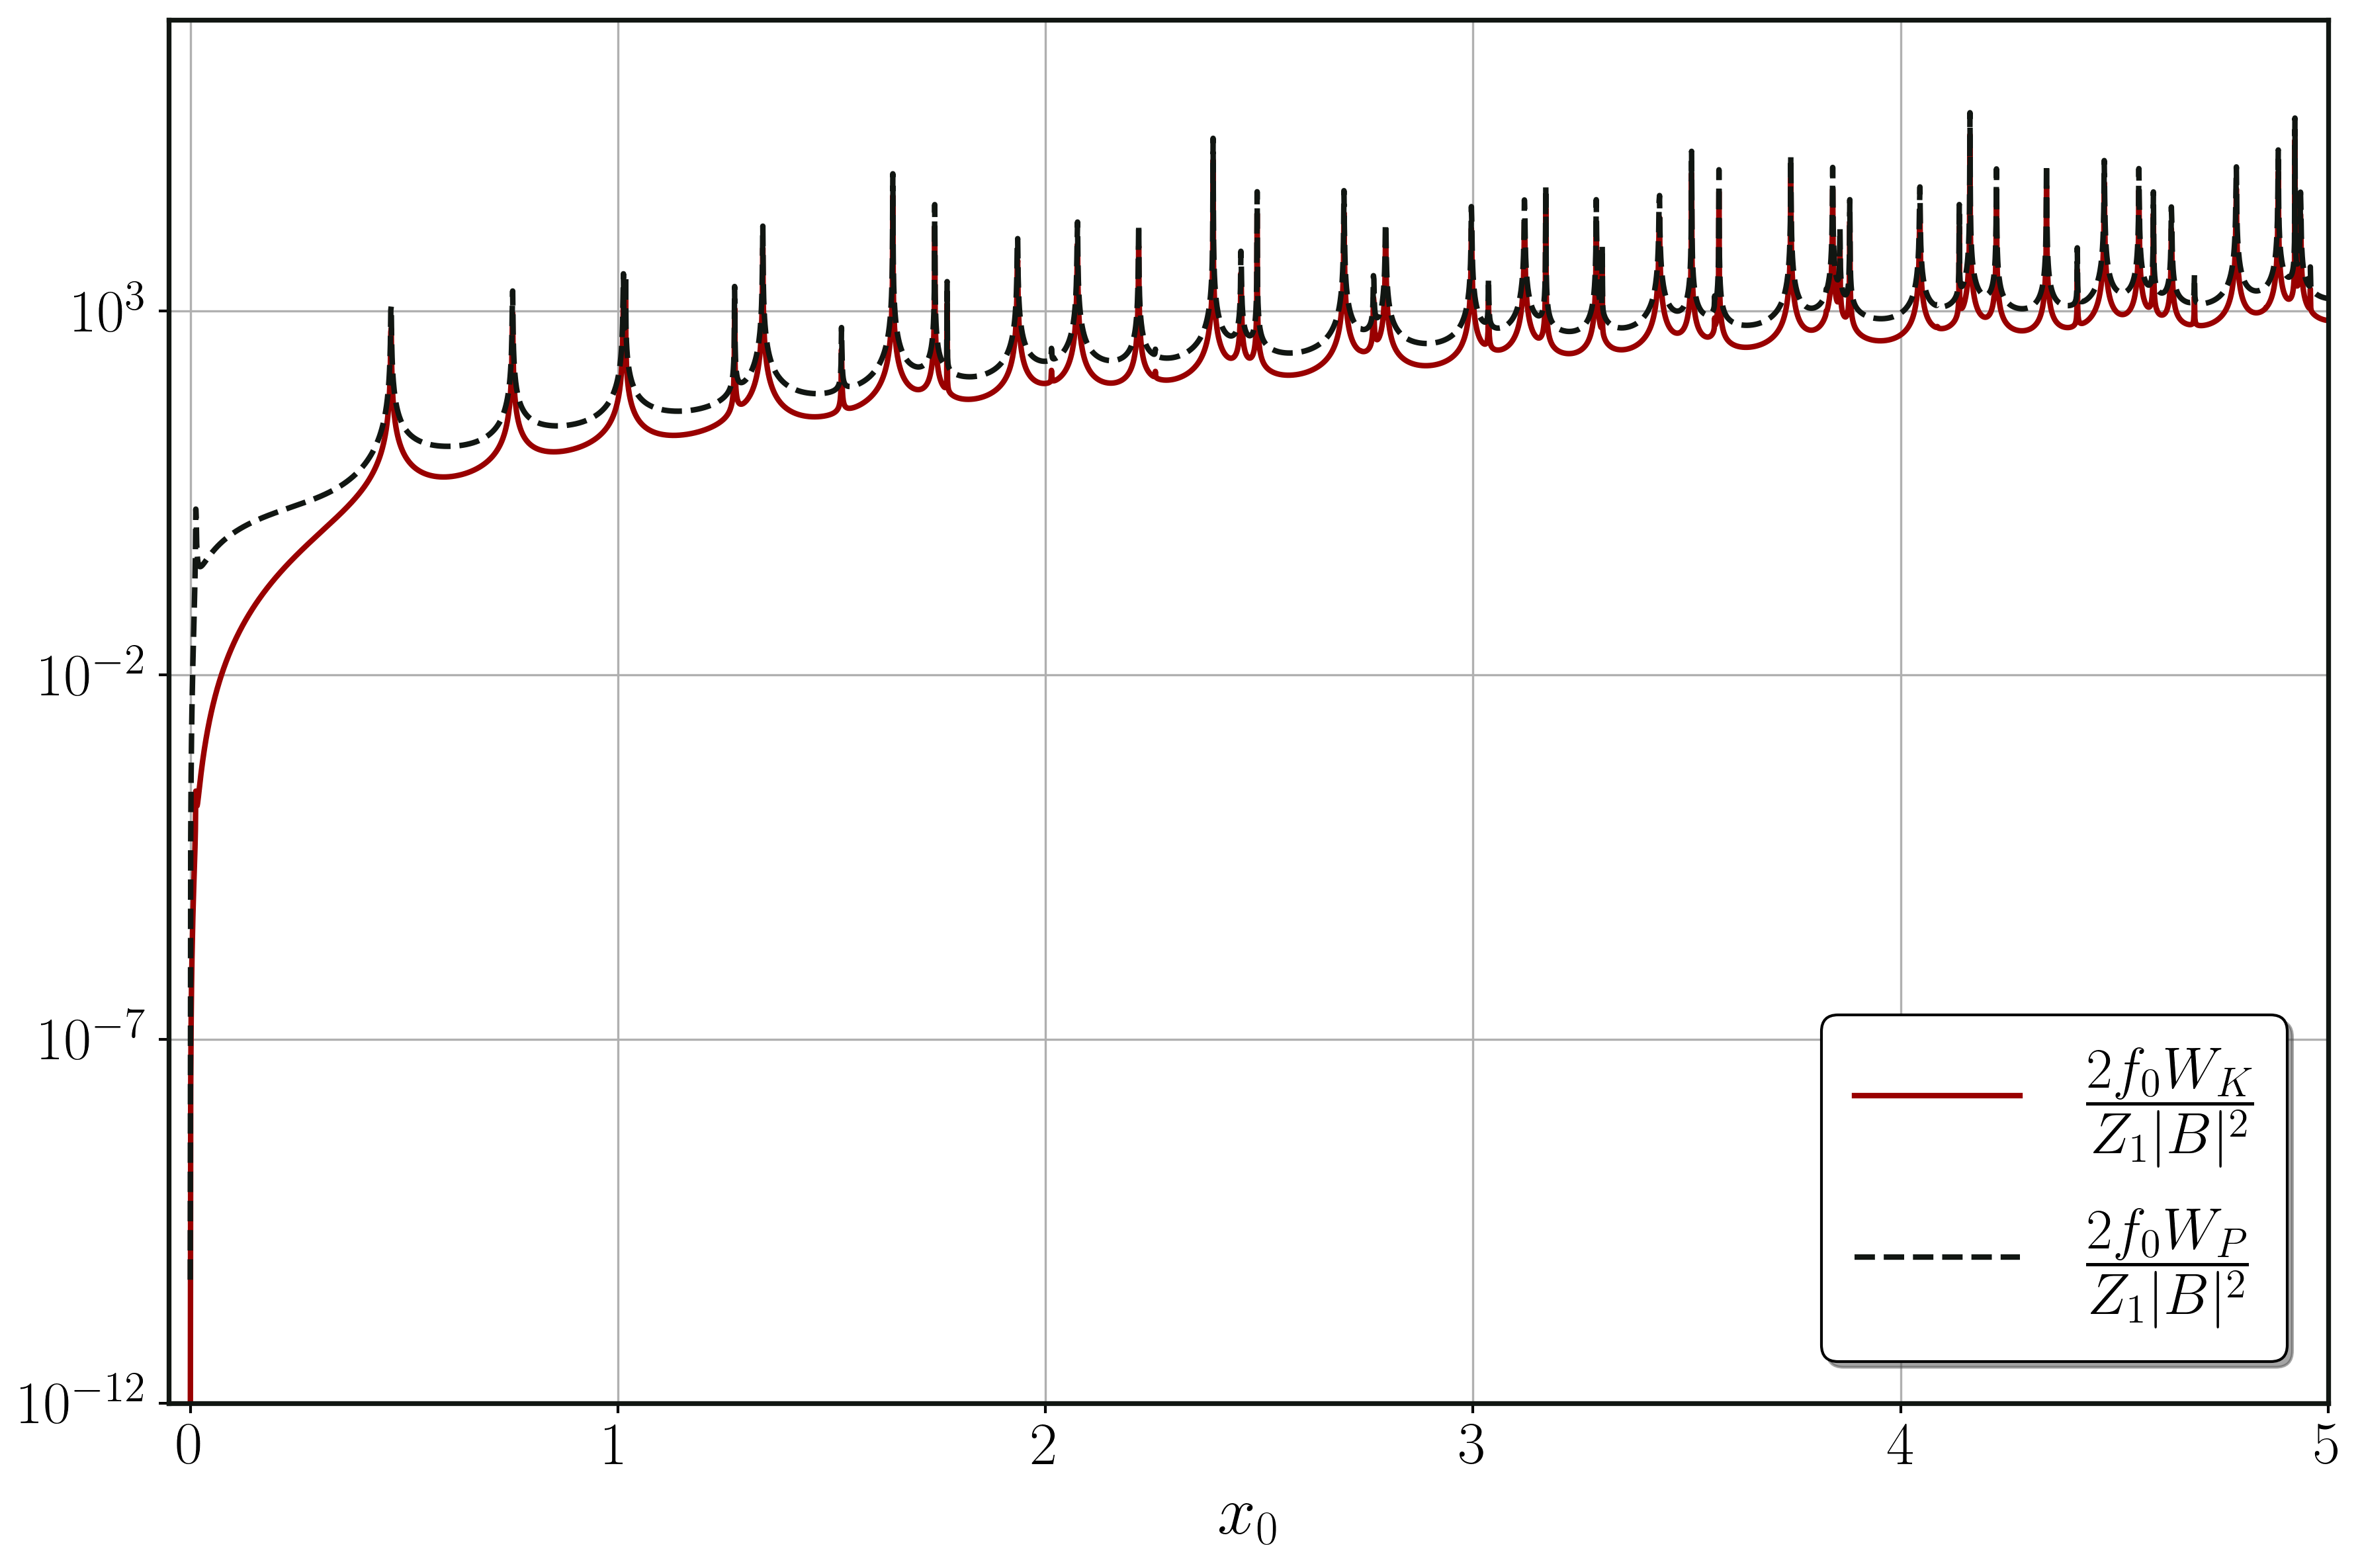

In [ ]:

# First plot
plt.figure(figsize=(12, 8))
plt.plot(x0_range, kinetic_energy, label=r'$\frac{2 f_0   W_K  }{Z_1 |B|^2 }$', linestyle='-', color='#990000', linewidth=2)
plt.plot(x0_range, potential_energy, label=r'$\frac{2 f_0   W_P  }{Z_1|B|^2 }$', linestyle='--', color='#111612', linewidth=2)
plt.yscale("log")
plt.xlabel('$x_0$', fontsize=25)
plt.xlim(0, 0.1)
plt.ylim(1e-12, 1e7)
plt.legend(fontsize=30, framealpha=1, edgecolor='black', shadow=True, fancybox=True, loc='lower right')
plt.grid(True)
plt.gca().yaxis.set_major_locator(ticker.LogLocator(numticks=4))
# Customize axes appearance for first plot
for spine in plt.gca().spines.values():
    spine.set_color('#111612')
    spine.set_linewidth(1.75)
plt.tick_params(axis='x', width=1, labelsize=22)
plt.tick_params(axis='y', width=1, labelsize=22)

# Save and show first plot
plt.tight_layout()
plt.savefig('/content/drive/My Drive/wpwk_01_l_zero.pdf', dpi=600, bbox_inches='tight', pad_inches=0.1)
plt.savefig('/content/drive/My Drive/wpwk_01_l_zero.png', dpi=600, bbox_inches='tight', pad_inches=0.1)
plt.savefig('/content/drive/My Drive/wpwk_01_l_zero.eps', dpi=600, bbox_inches='tight', pad_inches=0.1)
plt.show()

# Second plot
plt.figure(figsize=(12, 8))
plt.plot(x0_range_low_precision, kinetic_energy_low_precision, label=r'$\frac{2 f_0  W_K  }{Z_1 |B|^2 }$', linestyle='-', color='#990000', linewidth=2)
plt.plot(x0_range_low_precision, potential_energy_low_precision, label=r'$\frac{2 f_0   W_P }{Z_1 |B|^2 }$', linestyle='--', color='#111612', linewidth=2)
plt.yscale("log")
plt.xlabel('$x_0$', fontsize=25)
plt.xlim(-0.05, 5)
plt.ylim(1e-12, 1e7)
plt.legend(fontsize=30, framealpha=1, edgecolor='black', shadow=True, fancybox=True, loc='lower right')
plt.grid(True)
plt.gca().yaxis.set_major_locator(ticker.LogLocator(numticks=4))
# Customize axes appearance for second plot
for spine in plt.gca().spines.values():
    spine.set_color('#111612')
    spine.set_linewidth(1.75)
plt.tick_params(axis='x', width=1, labelsize=22)
plt.tick_params(axis='y', width=1, labelsize=22)

# Save and show second plot
plt.tight_layout()
plt.savefig('/content/drive/My Drive/wpwk_01.pdf', dpi=600, bbox_inches='tight', pad_inches=0.1)
plt.savefig('/content/drive/My Drive/wpwk_01.png', dpi=600, bbox_inches='tight', pad_inches=0.1)
plt.savefig('/content/drive/My Drive/wpwk_01.eps', dpi=600, bbox_inches='tight', pad_inches=0.1)
plt.show()



